<a href="https://colab.research.google.com/github/pamelamurilloa/DataMining-ISW911-ThirdProject-MachineLearning/blob/main/red_neuronal_secuencial_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto III - Machine Learning

## Descripción de las variables del dataset

1. **churn:** Indica si un cliente ha abandonado el servicio o no.
2. **accountlength:** Tiempo, en días, que el cliente lleva con el servicio.
3. **internationalplan:** Indica si el cliente tiene un plan de llamadas internacionales.
4. **voicemailplan:** Indica si el cliente tiene un plan de buzón de voz.
5. **numbervmailmessages:** Número de mensajes de voz recibidos por el cliente.
6. **totaldayminutes:** Total de minutos usados por el cliente durante el día.
7. **totaldaycalls:** Total de llamadas realizadas durante el día.
8. **totaldaycharge:** Costo total de las llamadas realizadas durante el día, en dólares.
9. **totaleveminutes:** Total de minutos usados por el cliente durante la tarde.
10. **totalevecalls:** Total de llamadas realizadas durante la tarde.
11. **totalevecharge:** Costo total de las llamadas realizadas durante la tarde, en dólares.
12. **totalnightminutes:** Total de minutos usados por el cliente durante la noche.
13. **totalnightcalls:** Total de llamadas realizadas durante la noche.
14. **totalnightcharge:** Costo total de las llamadas realizadas durante la noche, en dólares.
15. **totalintlminutes:** Total de minutos usados en llamadas internacionales.
16. **totalintlcalls:** Total de llamadas internacionales realizadas.
17. **totalintlcharge:** Costo total de las llamadas internacionales, en dólares.
18. **numbercustomerservicecalls:** Número de llamadas realizadas por el cliente al servicio de atención al cliente.

## 0. Cargar librerías previamente

In [616]:
# Carga de las librerias
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## 1. Cargar el Conjunto de datos


### Cargar datos desde el repositorio a un dataframe

In [528]:
url ='https://raw.githubusercontent.com/pamelamurilloa/DataMining-ISW911-ThirdProject-MachineLearning/refs/heads/main/datos.csv'
df = pd.read_csv(url)

### Transformaciones previas

In [529]:
# Validar como vienen originalmente los tipos datos
print(df.dtypes)

churn                          object
accountlength                 float64
internationalplan              object
voicemailplan                  object
numbervmailmessages           float64
totaldayminutes               float64
totaldaycalls                 float64
totaldaycharge                float64
totaleveminutes               float64
totalevecalls                 float64
totalevecharge                float64
totalnightminutes             float64
totalnightcalls               float64
totalnightcharge              float64
totalintlminutes              float64
totalintlcalls                float64
totalintlcharge               float64
numbercustomerservicecalls    float64
dtype: object


In [530]:
# Convertir las variables categóricas a un formato category (equivalente a factor en R)
columns_to_convert = ['churn', 'internationalplan', 'voicemailplan']
df[columns_to_convert] = df[columns_to_convert].astype('category')

print(df.dtypes)

churn                         category
accountlength                  float64
internationalplan             category
voicemailplan                 category
numbervmailmessages            float64
totaldayminutes                float64
totaldaycalls                  float64
totaldaycharge                 float64
totaleveminutes                float64
totalevecalls                  float64
totalevecharge                 float64
totalnightminutes              float64
totalnightcalls                float64
totalnightcharge               float64
totalintlminutes               float64
totalintlcalls                 float64
totalintlcharge                float64
numbercustomerservicecalls     float64
dtype: object


## 2. División de los datos en conjuntos de entrenamiento y prueba

In [531]:
# Separar el conjunto de datos en un conjunto de entrenamiento y uno de prueba

# Esta separación esta enfocada en la predección de 'churn'

# Variables independientes:
x = df.loc[:, df.columns != 'churn']

# Variable dependiente:
y = df['churn']

# Dividir los datos en subconjuntos aleatorios de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
print('Conjunto de datos separado para entrenamiento y prueba.')

Conjunto de datos separado para entrenamiento y prueba.


## 3. Justificación de la selección del modelo de Machine Learning

Las redes neuronales es un modelado poderoso para la predicción del 'Churn' debido a su capacidad para modelar relaciones complejas, de esta forma se pueden identificar múltiples interacciones complejan que afecten la elección de los clientes lo que una red neuronal puede aprender y modelar eficazmente. A pesar de que puede ser un modelo, complejo este se puede mantener un poco más simple, debido a su flexibilidad en la configuración y adaptación a los datos, esto debido a que nos permiten ajustar las números de capas y neuronas. Por lo que, su capacidad de modelado de relaciones, manejo de grandes cantidades de datos y flexibilidad podrían asegurar un modelo robusto, también son consideradas una 'caja negra', más sin embargo existen herramientas como lo es SHAP o LIME.

## 4. Entrenamiento de Modelos de Machine Learning (Red Neuronal)


### Preprocesamiento adicional

In [532]:
# Codificación de variables categóricas en las variables categóricas de entrenamiento independientes

# One-Hot Encoding, manteniendo sólo una columna '..._yes'para evitar colinealidad
x_train = pd.get_dummies(x_train, drop_first=True)
x_test = pd.get_dummies(x_test, drop_first=True)

# Asegurar que ambas divisiones tengan las mismas columnas
x_test = x_test.reindex(columns=x_train.columns, fill_value=0)

In [533]:
# Codificación de churn (variable dependiente), convirtiendolas en valores binarios

le = LabelEncoder()
y_train = le.fit_transform(y_train) # Aprendiendo que No -> 0, Yes -> 1
y_test = le.transform(y_test) # Aquí ya lo aprendió, por ende sólo transforma

# Confirmación del mapeo
print(le.classes_)

['No' 'Yes']


### Definir estructura del modelo y compilarlo

In [600]:
# Crear modelo de red neuronal secuencial
model = Sequential()

In [601]:
# Definir capas

# - Agregar la capa de entrada explícita:
model.add(Input(shape=(x_train.shape[1],)))

# - Primer capa oculta:
model.add(Dense(units=64, activation='relu'))

# - Regular con Dropout
model.add(Dropout(0.5))

# - Segunda capa oculta
model.add(Dense(units=32, activation='relu'))

# - Regular con Dropout
model.add(Dropout(0.5))

# - Capa de salida
model.add(Dense(units=1, activation='sigmoid'))

**Explicación:**

- La capa de entrada recibe los datos y especifica la forma de los datos,

- Para las primeras dos capas, se utilizan 64 y 32 neuronas debido a que es común y es preferido utilizar potencias de 2 como tendencia histórica. Estas introducen no linealidad y procesa interacciones más complejas, ya que este es su fin.

- Los regulizadores nos permiten apagar el 50% de las neuronas mientras se realiza su entrenamiento, esto nos permite evitar el sobreajuste, reduciendo la dependencia del modelo en conexiones de neuronas específicas.

- Para la capa de salida se utiliza `sigmoid` este devuelve una probabilidad, en la que si es mayor a 0.5 retorna 1, de lo contrario 0, lo cual nos ayuda a ilustrar la clasificación binaria, donde se posee sólo una salida por la misma razón, en la que se quiere predecir entres 'Yes' y 'No'.

### Compilar el modelo

In [602]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Calcular pesos de las variables

In [603]:
# Evalua el peso según la cantidad de 'no (0)' en contra las de 'yes (0)'
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict[1] = 2.2 # Se reduce el valor de 'yes' ya que es muy alto

print(f'Pesos de las variables: {class_weights_dict}')

Pesos de las variables: {0: 0.5843071786310517, 1: 2.2}


### Entrenar modelo

In [604]:
# Detiene el entrenamiento del modelo cuando no hay mejora
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Ajustar el modelo
history = model.fit(
    x_train, y_train,                # Datos de entrenamiento
    validation_split=0.2,            # Usar el 20% del entrenamiento como validación
    epochs=150,                      # Número máximo de épocas
    batch_size=64,                   # Tamaño del lote
    class_weight=class_weights_dict, # Aplicar pesos de las clases
    callbacks=[early_stopping],      # Para finalizar si después de 5 iteraciones no mejora
    verbose=2                        # Nivel de detalle de la salida
)

Epoch 1/150
44/44 - 3s - 74ms/step - accuracy: 0.5993 - loss: 0.5999 - val_accuracy: 0.8500 - val_loss: 0.5156
Epoch 2/150
44/44 - 0s - 9ms/step - accuracy: 0.7146 - loss: 0.5481 - val_accuracy: 0.8557 - val_loss: 0.5120
Epoch 3/150
44/44 - 0s - 5ms/step - accuracy: 0.7379 - loss: 0.5159 - val_accuracy: 0.8600 - val_loss: 0.4966
Epoch 4/150
44/44 - 0s - 7ms/step - accuracy: 0.7496 - loss: 0.5145 - val_accuracy: 0.8586 - val_loss: 0.4821
Epoch 5/150
44/44 - 0s - 7ms/step - accuracy: 0.7771 - loss: 0.5016 - val_accuracy: 0.8614 - val_loss: 0.4807
Epoch 6/150
44/44 - 0s - 5ms/step - accuracy: 0.7854 - loss: 0.5004 - val_accuracy: 0.8657 - val_loss: 0.4818
Epoch 7/150
44/44 - 0s - 5ms/step - accuracy: 0.7975 - loss: 0.4866 - val_accuracy: 0.8629 - val_loss: 0.4766
Epoch 8/150
44/44 - 0s - 7ms/step - accuracy: 0.7914 - loss: 0.4934 - val_accuracy: 0.8614 - val_loss: 0.4749
Epoch 9/150
44/44 - 0s - 3ms/step - accuracy: 0.8096 - loss: 0.4760 - val_accuracy: 0.8629 - val_loss: 0.4659
Epoch 10/

**Resultados del entrenamiento:**

- `accuracy`: Porcentaje de predicciones correctas entrenando.

- `loss`: Valor de la función de pérdida entrenando.

- `val_accuracy`: Porcentaje de predicciones correctas en el conjunto de validación.

- `val_loss`: Valor de la función de pérdida en el conjunto de validación.

### Visualizar resultados del rendimiento del entrenamiento

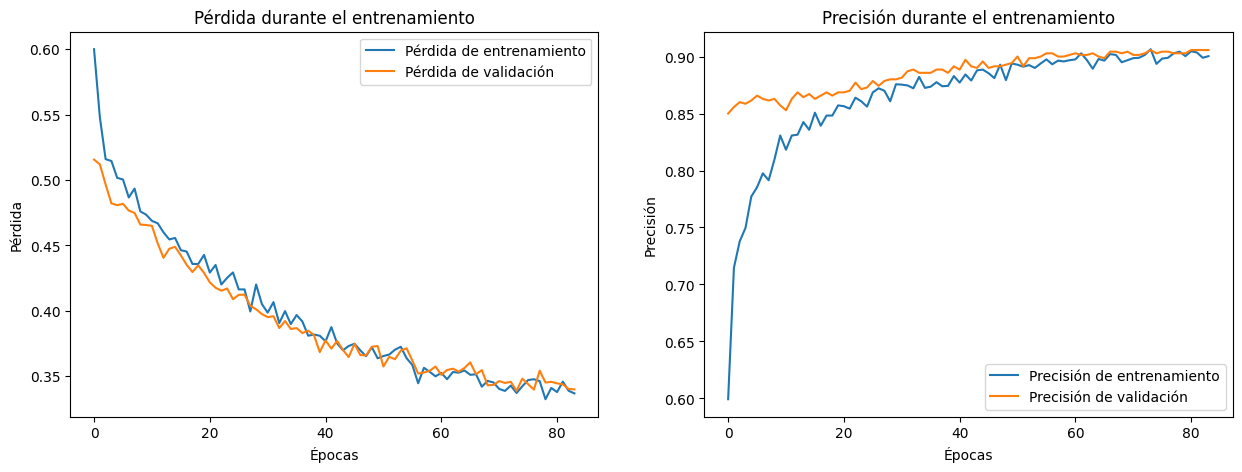

In [605]:
# Crear 2 columnas en 1 fila para los gráficos
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Pérdida
axes[0].plot(history.history['loss'], label='Pérdida de entrenamiento')
axes[0].plot(history.history['val_loss'], label='Pérdida de validación')
axes[0].legend()
axes[0].set_title('Pérdida durante el entrenamiento')
axes[0].set_xlabel('Épocas')
axes[0].set_ylabel('Pérdida')

# Precisión
axes[1].plot(history.history['accuracy'], label='Precisión de entrenamiento')
axes[1].plot(history.history['val_accuracy'], label='Precisión de validación')
axes[1].legend()
axes[1].set_title('Precisión durante el entrenamiento')
axes[1].set_xlabel('Épocas')
axes[1].set_ylabel('Precisión')

plt.show()

## 5. Evaluación del modelo

### Evaluar modelo con los datos de prueba

In [606]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9141 - loss: 0.3234
Test Loss: 0.3189217448234558, Test Accuracy: 0.909333348274231


### Matriz de confusión y métricas adicionales

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


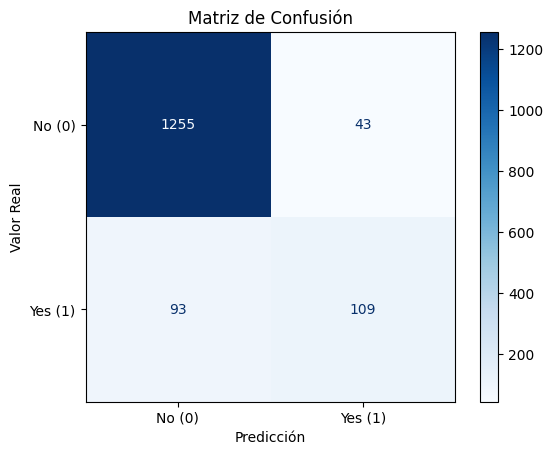

In [607]:
# Predicción elaborada
y_pred = (model.predict(x_test) > 0.5).astype("int32")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Mostrar gráficamente
def plot_confusion_matrix(cm):
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No (0)", "Yes (1)"])
  disp.plot(cmap=plt.cm.Blues, values_format='d')
  plt.xlabel("Predicción")
  plt.ylabel("Valor Real")
  plt.title("Matriz de Confusión")
  plt.show()

plot_confusion_matrix(cm)

In [608]:
# Métricas adicionales
print("Métricas Adicionales:")
print(classification_report(y_test, y_pred))

Métricas Adicionales:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1298
           1       0.72      0.54      0.62       202

    accuracy                           0.91      1500
   macro avg       0.82      0.75      0.78      1500
weighted avg       0.90      0.91      0.90      1500



### Calculo de Métricas (MSE y MAE)

In [609]:
# Generar las predicciones del modelo (en probabilidades)
y_pred_prob = model.predict(x_test)

# Convertir las probabilidades a 0/1:
y_pred_class = (y_pred_prob > 0.5).astype("int32")

# Calcular el Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred_prob)
print("Error cuadrático medio (MSE):", mse)

# Calcular el Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred_prob)
print("Error absoluto medio (MAE):", mae)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Error cuadrático medio (MSE): 0.08921045915538213
Error absoluto medio (MAE): 0.23403878787222007


### Curva ROC y AUC

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


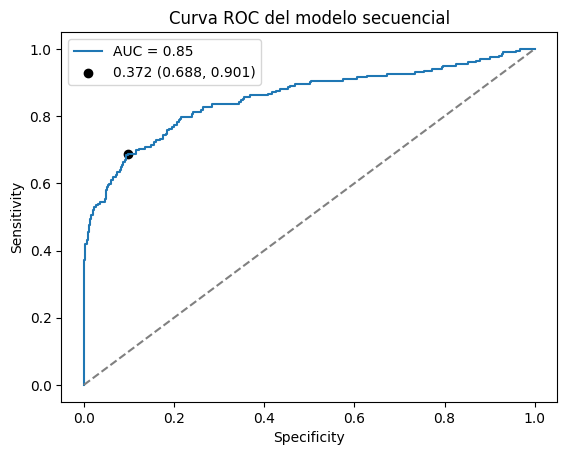

In [610]:
# Calcula fpr, tpr, y thresholds
y_pred_prob = model.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc_score = auc(fpr, tpr)

# Encuentra el índice del umbral más cercano al valor deseado
index = (tpr - fpr).argmax()
threshold_selected = thresholds[index]
sensitivity = tpr[index]
specificity = 1 - fpr[index]

plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.scatter(fpr[index], tpr[index], color="black", label=f"{threshold_selected:.3f} ({sensitivity:.3f}, {specificity:.3f})")
plt.xlabel("Specificity")
plt.ylabel("Sensitivity")
plt.title("Curva ROC del modelo secuencial")
plt.legend()
plt.show()

## 6. Ajustes de Parámetros

### Ajustes implementados previamente en el área de entrenamiento

1 - Ajustar arquitectura:

La arquitectura inicial era la siguiente:

```
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(36, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
```

- Capas entrada: Se agregó una entrada explicita que ayuda a especificar las características y es la función recomendada de hacerlo según keras.

- Capas ocultas: La cantidad de neuronas y las funciones de activación en las dos capas ocultas no fueron modificadas.

- Regulizadores (Dropout): Se añadió un Dropout del 50% después de cada capa oculta. Esto fuerza al modelo a desactivar aleatoriamente la mitad de las neuronas durante cada iteración de entrenamiento, ayudando a evitar el sobreajuste.

2 - Pesos de las clases

Uno de los ajustes implementados fue el pesos de las clases, el cual se calcula utilizando compute_class_weight de sklearn, donde luego en la función fit() en el párametro class_weight. Además, debido a que el valor computado para la clase 1 (Yes) era muy alto con el siguiente código se busco un valor más eficiente que no desbalancerá tanto los resultados.

```py
minority_weights = np.arange(1.0, 5.5, 0.5)  # Peso de la clase 1 (Churn)

results = []

for weight in minority_weights:
    class_weights_dict = {0: 0.58, 1: weight}
    model_test = clone_model(model)
    model_test.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    model_test.fit(
        x_train, y_train,
        validation_split=0.2,
        epochs=50,  # Reducir para pruebas rápidas
        batch_size=64,
        class_weight=class_weights_dict,
        verbose=0
    )
    
    y_pred = (model_test.predict(x_test) > 0.5).astype("int32")
    report = classification_report(y_test, y_pred, output_dict=True)
  
    results.append({
        "weight_1": weight,
        "precision_1": report['1']['precision'],
        "recall_1": report['1']['recall'],
        "f1_score_1": report['1']['f1-score'],
        "accuracy": report['accuracy']
    })
```

Los resultados más óptimos se dieron cerca de dos, por ende a base de prueba y error se dio con **2.2**.

3 - Valores de entrenamiento

Con respecto, a los valores de entrenamiento estos fueron probados y ajustados decenas de veces hasta encontrar este resultado ideal, donde las `epochs`, `batch_size` y la `patience` del mecanismo que para el entreamiento si no ve mayor progreso, fueron los más ajustados dentro de este proceso.

### Ajustar el Umbral

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


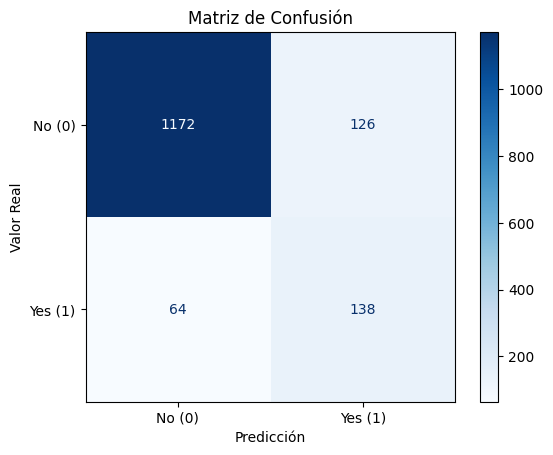


Reporte de Clasificación con umbral ajustado:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93      1298
           1       0.52      0.68      0.59       202

    accuracy                           0.87      1500
   macro avg       0.74      0.79      0.76      1500
weighted avg       0.89      0.87      0.88      1500



In [612]:
y_pred = model.predict(x_test)

# Ajustar el umbral
threshold = 0.372
y_pred_custom = (y_pred > threshold).astype("int32")

cm = confusion_matrix(y_test, y_pred_custom)
plot_confusion_matrix(cm)

# Métricas de clasificación
print("\nReporte de Clasificación con umbral ajustado:")
print(classification_report(y_test, y_pred_custom))

In [613]:
model.save('model.keras')

### 7. Interpretación del modelo


### ¿Cómo hace predicciones el modelo?

#### Analizar algunos resultados

In [614]:
# Generar las probabilidades de las predicciones
y_pred_prob = model.predict(x_test)

# Verificar las primeras 10 probabilidades
print("Probabilidades generadas por el modelo (primeros 10 casos):")
print(y_pred_prob[:10])

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Probabilidades generadas por el modelo (primeros 10 casos):
[[0.24500504]
 [0.02443279]
 [0.15469386]
 [0.9599892 ]
 [0.36373824]
 [0.18423805]
 [0.14755543]
 [0.3501113 ]
 [0.35323367]
 [0.08389694]]


#### Espacios de predicción pro clase

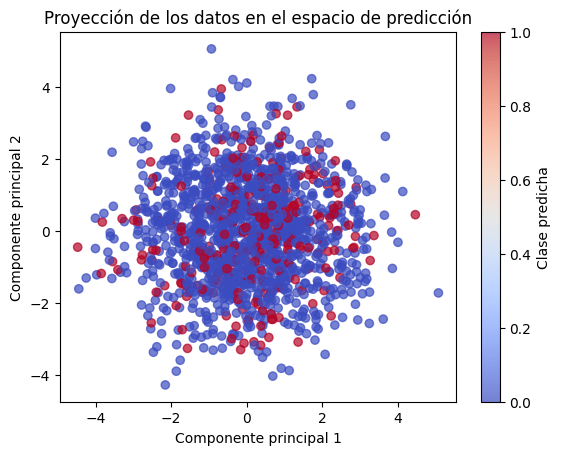

In [615]:
# Reducir la dimensionalidad a 2D
pca = PCA(n_components=2)
x_test_pca = pca.fit_transform(x_test)

# Visualizar datos con las predicciones del modelo
plt.scatter(x_test_pca[:, 0], x_test_pca[:, 1], c=y_pred_custom, cmap='coolwarm', alpha=0.7)
plt.title("Proyección de los datos en el espacio de predicción")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.colorbar(label="Clase predicha")
plt.show()

### Importancia por variable

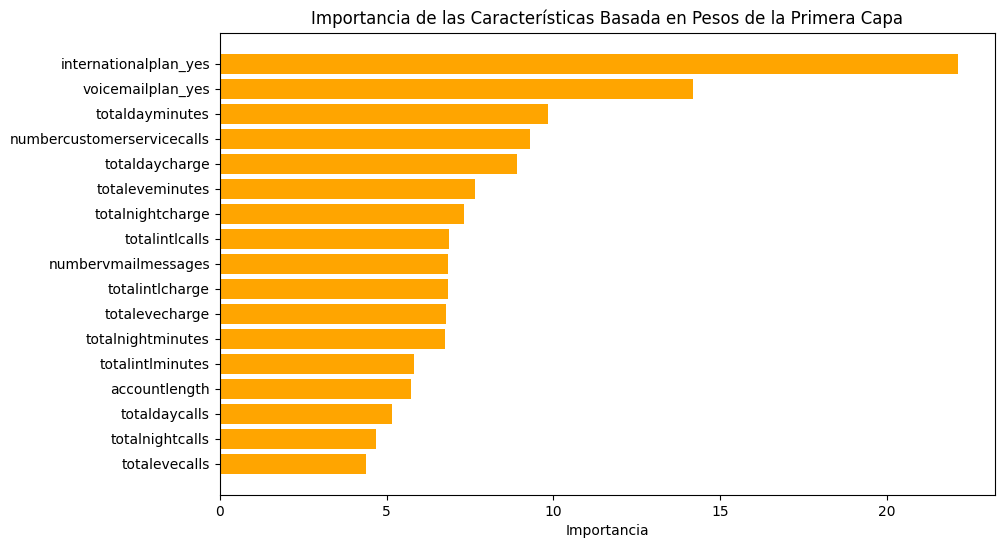

In [619]:
# Obtener los pesos de la primera capa
weights, _ = model.layers[0].get_weights()

# Calcular la importancia como la suma absoluta de los pesos por cada característica
feature_importances = np.sum(np.abs(weights), axis=1)

# Crear un DataFrame para ordenar las características
importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Mostrar la importancia por característica
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color="orange")
plt.xlabel('Importancia')
plt.title('Importancia de las Características Basada en Pesos de la Primera Capa')
plt.gca().invert_yaxis()
plt.show()

## 8. Predicción y uso del modelo

### Nuevos datos

In [661]:
random_raw_test = x_test.sample(n=1, random_state=42).iloc[0]
random_raw_train = x_test.sample(n=1, random_state=42).iloc[0]

new_data = pd.DataFrame({
    'accountlength': [random_raw_test['accountlength']],
    'internationalplan_yes': [random_raw_train['internationalplan_yes']],
    'voicemailplan_yes': [random_raw_test['voicemailplan_yes']],
    'numbervmailmessages': [random_raw_train['numbervmailmessages']],
    'totaldayminutes': [random_raw_test['totaldayminutes']],
    'totaldaycalls': [random_raw_train['totaldaycalls']],
    'totaldaycharge': [random_raw_test['totaldaycharge']],
    'totaleveminutes': [random_raw_train['totaleveminutes']],
    'totalevecalls': [random_raw_test['totalevecalls']],
    'totalevecharge': [random_raw_train['totalevecharge']],
    'totalnightminutes': [random_raw_test['totalnightminutes']],
    'totalnightcalls': [random_raw_train['totalnightcalls']],
    'totalnightcharge': [random_raw_test['totalnightcharge']],
    'totalintlminutes': [random_raw_train['totalintlminutes']],
    'totalintlcalls': [random_raw_test['totalintlcalls']],
    'totalintlcharge': [random_raw_train['totalintlcharge']],
    'numbercustomerservicecalls': [random_raw_test['numbercustomerservicecalls']]
})

new_data

,accountlength,internationalplan_yes,voicemailplan_yes,numbervmailmessages,totaldayminutes,totaldaycalls,totaldaycharge,totaleveminutes,totalevecalls,totalevecharge,totalnightminutes,totalnightcalls,totalnightcharge,totalintlminutes,totalintlcalls,totalintlcharge,numbercustomerservicecalls
0,-1.177365,False,False,-0.599339,-1.215378,0.983291,-1.214997,-1.597537,1.180265,-1.597784,0.350773,0.061296,0.351853,0.668652,-1.19118,0.667977,-0.205609


### Predecir sobre los nuevos datos

In [662]:
# Predicciones con el modelo entrenado
y_pred_prob = model.predict(new_data)
threshold = 0.349
y_pred_custom = (y_pred_prob > threshold).astype("int32")

print("Probabilidades de Churn:", y_pred_prob)
print("Predicciones ajustadas:", y_pred_custom)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Probabilidades de Churn: [[0.28935906]]
Predicciones ajustadas: [[0]]
